In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
sns.set_theme()

In [2]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

In [3]:
data = pd.read_parquet('../data/all_data.parquet')

In [4]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 461301 entries, 0 to 461300
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   title               461301 non-null  object 
 1   title_link          461301 non-null  object 
 2   issue_link          461301 non-null  object 
 3   cover_link          461301 non-null  object 
 4   issue               461301 non-null  object 
 5   cover_date          369712 non-null  object 
 6   cover_price         461301 non-null  object 
 7   current_value       461301 non-null  object 
 8   hist_prices_link    461301 non-null  object 
 9   searched            461301 non-null  int64  
 10  owned               461301 non-null  int64  
 11  pages               208011 non-null  float64
 12  rating              461301 non-null  float64
 13  rating_count        461301 non-null  int64  
 14  ISBN-UPC            197912 non-null  object 
 15  est_print_run       30446 non-null

In [5]:
titles = pd.read_csv('../data/titles_list_data.csv', low_memory=False, index_col=[0])

In [6]:
titles.title.duplicated().value_counts()
# there are identical titles so we have to connect them with a unique id for convenience

False    59483
True      7397
Name: title, dtype: int64

In [7]:
data.issue_link[0]

'https://comicbookrealm.com/series/4036/54341/dc-comics-mazing-man-issue-1'

In [8]:
# extract titles' and issues' unique ids
data['title_id'] = data.title_link.str.extract(pat=r'/series.(.+\d)/\d.+')
data['issue_id'] = data.issue_link.str.extract(pat=r'/series/.+\d/(.+\d)/.+')

In [9]:
# keep relevant columns
df = data[['pub_name', 'title', 'title_id', 'issue', 'variant_of', 'cover_date', 
           'years', 'cover_price', 'current_value', 'searched', 
          'owned', 'volume', 'issues_total',
           'pub_titles_total', 'pub_issues_total',
           'contributors_names', 'contributors_roles', 'characters']]

In [10]:
# turn prices into numerical
df.loc[:, 'cover_price'] = df.loc[:, 'cover_price'].str.replace('[$,]', '', regex=True)
df.loc[:, 'cover_price'] = df.loc[:, 'cover_price'].str.replace('Free', '0', regex=False)
df.loc[:, 'cover_price'] = df.loc[:, 'cover_price'].apply(eval)

In [11]:
df.loc[:, 'current_value'] = df.loc[:, 'current_value'].str.replace('[$,]', '', regex=True)
df.loc[:, 'current_value'] = df.loc[:, 'current_value'].str.replace('Free', '0', regex=False)
df.loc[:, 'current_value'] = df.loc[:, 'current_value'].apply(eval)

In [12]:
# Many issues with cover price 0 have high current value so we keep them
df[df.cover_price == 0].sort_values('current_value', ascending=False).head(5)

,pub_name,title,title_id,issue,variant_of,cover_date,years,cover_price,current_value,searched,owned,volume,issues_total,pub_titles_total,pub_issues_total,contributors_names,contributors_roles,characters
44922,DC Comics,Superman Comics,47267,Ashcan,None,None,1939,0.0,300000.0,97,1,One-Shot,1.0,4688,57043,no contributors assigned,no contributors assigned,no characters assigned
569,DC Comics,Action Comics,2618,# 2,None,Jul '38,1938-2011 2016-Present,0.0,175000.0,18536,7,Vol. 1,1269.0,4688,57043,"['Bernard Baily', 'Russell Cole', 'Sven Elven'...","['Pencils-Inks', 'Scripts-Pencils-Inks', 'Penc...","[['Adam Springer', '/avatars/default.gif', '(N..."
1552,DC Comics,Action Comics,2618,# 8b,Issue # 8,Dec '38,1938-2011 2016-Present,0.0,56750.0,3057,2,Vol. 1,1269.0,4688,57043,"['Joe Shuster', 'Jerry Siegel']","['Pencils', 'Scripts']","[['Box-Ears', '/character-photos/character_324..."
260820,Eastern Color Printing Co.,Century of Comics,31667,nn,None,1933,1933,0.0,46000.0,17,0,One-Shot,1.0,19,400,no contributors assigned,no contributors assigned,no characters assigned
368677,"First Funnies, Inc.",Motion Picture Funnies Weekly,12104,# 1,None,Apr '39,1939,0.0,35000.0,1680,2,None,4.0,1,4,"['Bill Everett', 'Fred Schwab']","['Pencils-Inks', 'CoverArt']","[['Namor the Sub-Mariner', '/character-photos/..."


### `issue` column

There are several types of issues as indicated by their numbering and many strange numberings:

* Simple ascending numbering # 1-...
* 'Ashcan' Issues which are traditionally used to promote a new series (see [wiki](https://en.wikipedia.org/wiki/Ashcan_comic)). Ashcan comics can be quite rare and valuable, especially from the [Golden Age](https://en.wikipedia.org/wiki/Golden_Age_of_Comic_Books) (30s-50s)
* Issues with `nn` meaning 'non-numbered'. Typically 0th issues or one-shots
* Issues with numbering of the format: # (number)(variant-cover/ special ed./ convention ed. etc.): Normally these issues should be indicated as "variant of" (issue number) in the `variant_of` column
* Of "Vol ** # **" format (where ** indicated a number). i.e. two enumerations are indicated, one for volume, one for issue number
* Instead of issue number a date is given e.g. "Spring 2007" or simply "1989"
* Numbering which includes letters e.g. "C-2" or "x"
* Just the name of the protagonist or in general something explanatory e.g. "Batwoman"
* The print run is indicated e.g. '# 2 - 2nd print'


In [13]:
df_original = df.copy()

In [14]:
properdate = pd.read_csv('../data/proper_date.csv', low_memory=False)

In [15]:
df['proper_date'] = properdate

In [16]:
df.dropna(subset=['proper_date'], inplace=True)

In [17]:
df['year'] = pd.to_datetime(df['proper_date']).dt.year.apply(int) 
df['month'] = pd.to_datetime(df['proper_date']).dt.month.apply(int) 

In [18]:
# Global plot parameteres
plt.rcParams['figure.figsize'] = 10,8
sns.set(font_scale=1.5, style='dark')
plt.style.use("dark_background")

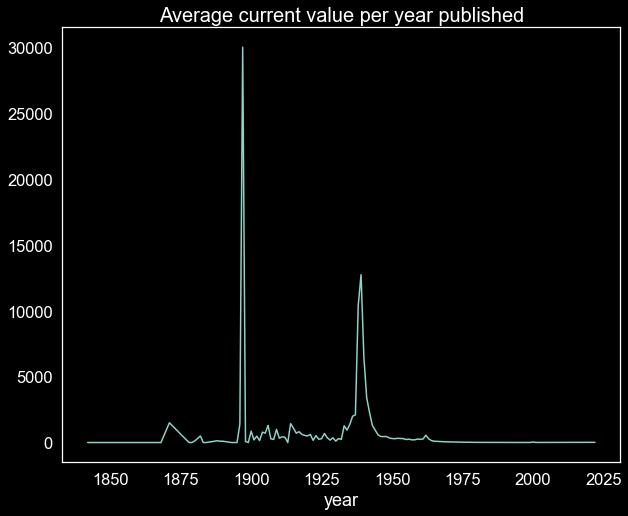

In [19]:
df_to_plot = df.groupby('year').mean()['current_value']
title='Average current value per year published'

df_to_plot.plot()
plt.title(title, size=20)

save_loc = '../presentation/' + title + '.png'
plt.savefig(save_loc, dpi=200, transparent=True)

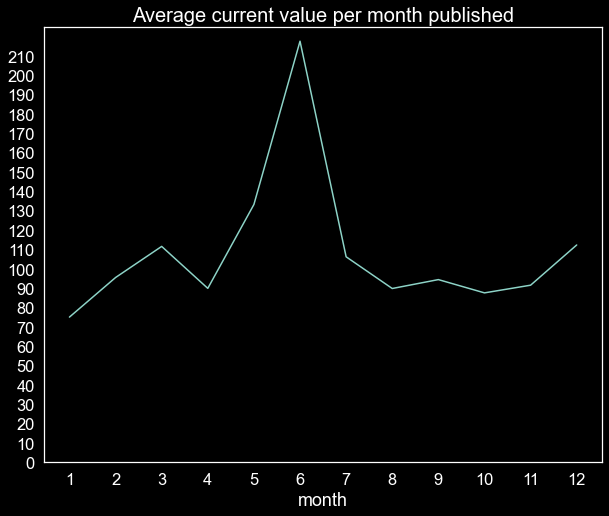

In [20]:
df_to_plot = df.groupby('month').mean()['current_value']
title = 'Average current value per month published'

df_to_plot.plot()
plt.title(title, size=20)
plt.xticks(np.arange(1, 13, 1.0))
plt.yticks(np.arange(0, 220, 10.0))

save_loc = '../presentation/' + title + '.png'
plt.savefig(save_loc, dpi=200, transparent=True)

In [21]:
df_stats = pd.DataFrame(columns = ['Description', 'Value'])

In [ ]:
Description = 'Number of issues'
Value = len(df_original)
df_stats = df_stats.append({'Description': Description, 'Value': Value}, ignore_index=True)

In [ ]:
Description = 'Number of titles'
Value = len(df_original['title'].value_counts())
df_stats = df_stats.append({'Description': Description, 'Value': Value}, ignore_index=True)

In [ ]:
Description = 'Average issues per title'
Value = len(df_original)/len(df_original['title'].value_counts())
df_stats = df_stats.append({'Description': Description, 'Value': Value}, ignore_index=True)

In [ ]:
Description = 'Average current value (USD)'
Value = df_original['current_value'].mean()
df_stats = df_stats.append({'Description': Description, 'Value': Value}, ignore_index=True)

In [ ]:
Description = 'Average cover price (USD)'
Value = df_original['cover_price'].mean()
df_stats = df_stats.append({'Description': Description, 'Value': Value}, ignore_index=True)

In [ ]:
Description = 'Number of publishers'
Value = len(df_original['pub_name'].value_counts())
df_stats = df_stats.append({'Description': Description, 'Value': Value}, ignore_index=True)

In [ ]:
Description = 'Average titles per publisher'
Value = len(df_original['title'].value_counts())/len(df_original['pub_name'].value_counts())
df_stats = df_stats.append({'Description': Description, 'Value': Value}, ignore_index=True)

In [ ]:
df_stats.to_excel("../presentation/stats.xlsx")

In [ ]:
df_stats